# CNN

## CNNとは

　多層ニューラルネットワークの各層の役割を以下のように与えることで、画像認識において抜群の性能を実現したのが、「畳込みニューラルネットワーク」CNN（Convolutional Neural Network）。

　　　　<img src="fig/cnn1.png" width="50%">


## 畳込み層

　画像の局所的な特徴抽出を行う。畳込みフィルターを適用して特徴マップを作成する。

畳込みフィルターのことを「カーネル」と呼ぶこともある。畳込みフィルターのパラメータが学習により最適化される。

　　　　<img src="fig/cnn2.png" width="80%">

## パディングとストライド

- パディング：畳み込み層の入力データのまわりにダミーデータを埋める。出力が小さくなりすぎないようにするため。
- ストライド：畳み込みフィルターを適用する間隔。

　　　　<img src="fig/cnn3.png" width="80%">


## プーリング層
　画像の解像度を落とし、本質的な特徴のみを抽出する。「最大プーリング」や「平均プーリング」と呼ばれる手法がある。

　　　　<img src="fig/cnn4.png" width="50%">

## 全結合層
- 各層のユニットを結合する。
- 手書き画像認識の場合は、ソフトマックス関数を使用する


## CNNによるMNISTの手書き文字認識
　シンプルな単層CNNを実装してみる。
- フィルター数は32個とする。
- フィルターサイズは、５Ｘ５とする。
- フィルターの値も学習により決定する。
- プーリング層で、２８Ｘ２８の画像を１４Ｘ１４へ縮小する。
- 全結合層の活性化関数は、ReLUを使用
- 出力値は、softmax関数を使用


### データ読み込み

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical


(X_train, y_train), (X_test, y_test) = mnist.load_data()

Y_train = to_categorical(y_train, 10)# 5 -> [0,0,0,0,1,0,0,0,0,0]
Y_test = to_categorical(y_test, 10)

X_train = X_train.reshape(60000, 28,28,1) #2次元データのままで良い
X_test = X_test.reshape(10000, 28,28,1)


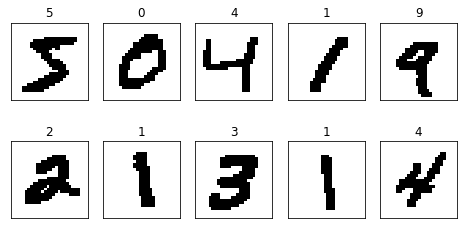

In [3]:
%matplotlib inline
fig = plt.figure(figsize=(8,4))
for c, (image, label) in enumerate(zip(X_train[:10], Y_train[:10])):
    subplot = fig.add_subplot(2,5,c+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(label))
    subplot.imshow(image.reshape((28,28)), vmin=0, vmax=1,
                   cmap=plt.cm.gray_r,  interpolation="nearest")

### 計算モデルの定義

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

model = Sequential()

#畳み込み層　１層目
model.add(
    Conv2D(
        filters=32,#フィルター数
        input_shape=(28,28,1),#入力画像次元
        kernel_size=(5,5),#フィルターサイズ
        strides=(1,1),
        padding='same',
        activation='relu'
    )
)

# プーリング層 1 層目
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) #２次元→１次元

model.add(Dense(units=512,activation='relu'))
model.add(Dense(units=10,activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## 計算実行

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

tsb = TensorBoard(log_dir='./mnist_cnn_log')

history = model.fit(
    X_train,
    Y_train,
    batch_size=100,
    epochs=15,
    validation_split=0.2,
    callbacks=[tsb]
)

### 評価

In [6]:
model.evaluate(X_test,Y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.1427 - accuracy: 0.9805


[0.14274777472019196, 0.9804999828338623]

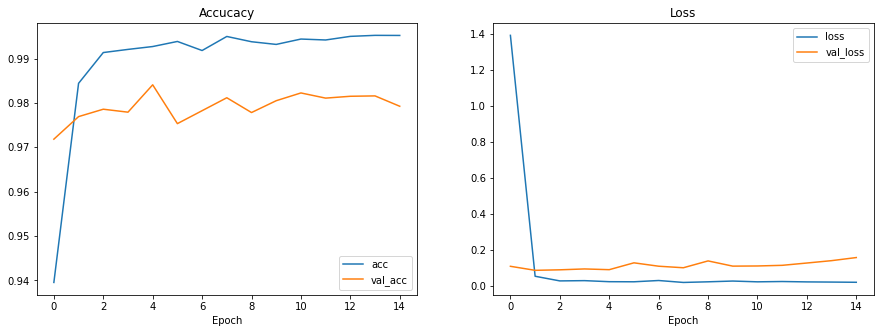

In [13]:
fig = plt.figure(figsize=[15, 5])

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Accucacy')
ax1.set_xlabel('Epoch')
ax1.plot(history.history['accuracy'], label='acc')
ax1.plot(history.history['val_accuracy'], label='val_acc')
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.plot(history.history['loss'], label='loss')
ax2.plot(history.history['val_loss'], label='val_loss')
ax2.legend()

plt.show()



### 畳込み層フィルター確認


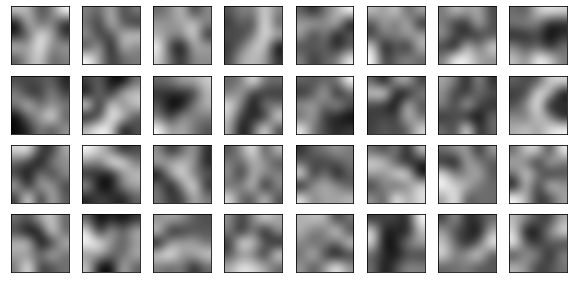

In [7]:
filter_vals= model.weights[0]

fig = plt.figure(figsize=(10,10))

for f in range(32):
    subplot = fig.add_subplot(8, 8, f+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:,:,0,f],
                   cmap=plt.cm.gray_r, interpolation='bicubic') 

### 畳込み層フィルターを適用した画像の確認

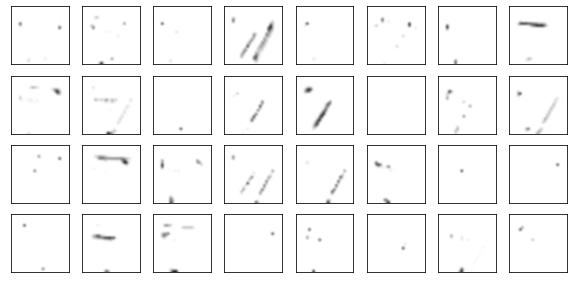

In [8]:
y = model.layers[0].call(X_test[0].astype('float32').reshape(-1,28,28,1))

fig = plt.figure(figsize=(10,10))

for f in range(32):
    subplot = fig.add_subplot(8, 8, f+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(y[0,:,:,f],
                   cmap=plt.cm.gray_r, interpolation='bicubic') 

## 過学習
　過学習(overfitting)とは、訓練データに対して学習されているが、未知のデータに対して適合できていない状態。

- 原因は以下
  - 訓練データ量が少ない
  - 訓練データが偏っている。

- 主な理論的な対策
  - 重み減衰
  - ドロップアウト

### 重み減衰

　重みの発散を防ぐため正則化項を加える。正則化とは、重みの自由度に制限を加える方法のこと。

　損失関数(誤差関数)に重みの1次式を加えるL1正則化、2次式を加えるL2正則化がある。

　$ L(w) $ を元の損失関数として、重み減衰を考慮した損失関数は、以下のようになる。

L1正則化

$$
L(w) + \lambda \sum_{i=0}^{n}|w_i|
$$

L2正則化

$$
L(w) + \frac{\lambda}{2} \sum_{i=0}^{n}w_i^2
$$

 　　　　　　　　　　　　　　　　　　　　　($ \lambda $ は微小な定数値)

### ドロップアウト
　一定の確率でユニットの出力を０にすることで、過学習を防ぐ考え方。

　　　　<img src="fig/dropout.png" width="50%">

### ドロップアウトと正則化を組み入れた実装例

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

model = Sequential()

#畳み込み層　１層目
model.add(
    Conv2D(
        filters=32,
        input_shape=(28,28,1),kernel_size=(5,5),
        strides=(1,1),padding='same',
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(units=512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=10,activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import TensorBoard

tsb = TensorBoard(log_dir='./mnist_cnn2_log')

history = model.fit(
    X_train,
    Y_train,
    batch_size=100,
    epochs=15,
    validation_split=0.2,
    callbacks=[tsb]
)

In [11]:
model.evaluate(X_test, Y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.0592 - accuracy: 0.9859


[0.059249769896268845, 0.9858999848365784]

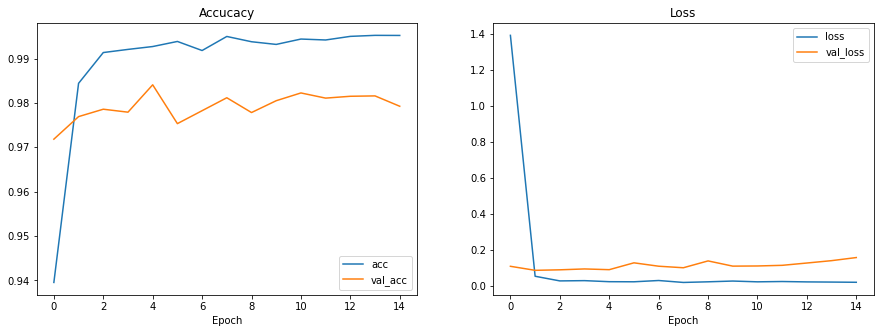

In [13]:
fig = plt.figure(figsize=[15, 5])

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Accucacy')
ax1.set_xlabel('Epoch')
ax1.plot(history.history['accuracy'], label='acc')
ax1.plot(history.history['val_accuracy'], label='val_acc')
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.plot(history.history['loss'], label='loss')
ax2.plot(history.history['val_loss'], label='val_loss')
ax2.legend()

plt.show()

